In [1]:
import os
import random
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import os

cuda


In [2]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
)


In [3]:
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('last_model.pth'))


<All keys matched successfully>

In [4]:
model.eval()

DataParallel(
  (module): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [18]:
def transform_image(img):
    img = img.resize((224, 224), resample=Image.BICUBIC)
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    img = (img - 0.5) / 0.5
    img = torch.from_numpy(img)
    return img

In [19]:
img = Image.open("photo_2024-02-27_15-15-26.jpg").convert("RGB")
img2 = img.resize((224, 224), resample=Image.BICUBIC)

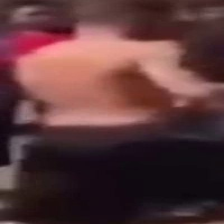

In [20]:
img2

In [21]:
img = transform_image(img)

In [22]:
img.shape

torch.Size([224, 224, 3])

In [23]:
img = img.permute(2, 0, 1)

In [24]:
img.shape

torch.Size([3, 224, 224])

In [25]:
img = img.unsqueeze(0)

In [26]:
img.shape

torch.Size([1, 3, 224, 224])

In [27]:
out = model(img)

In [28]:
out = torch.argmax(out, dim=1)

In [29]:
out = out.cpu()

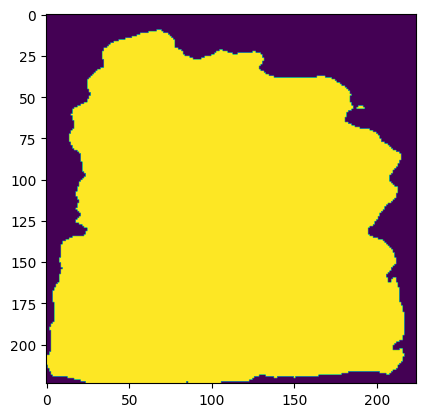

In [30]:
from matplotlib import pyplot as plt

plt.imshow(out[0])

In [72]:
import os
import numpy as np
import torch
from PIL import Image
import cv2
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pre-trained model
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
)
model = torch.nn.DataParallel(model)
# Load model weights
model.load_state_dict(torch.load('last_model.pth'))

model.eval()

# Define video input and output paths
video_path = "H:\\datasets\\неразмеченые люди\\0-2000\\100track_1.avi"
import numpy as np
import cv2


# Открываем видеофайл
cap = cv2.VideoCapture(video_path)

# Массив для хранения всех кадров
frames = []

# Считываем и сохраняем каждый кадр
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

# Преобразуем массив кадров в NumPy массив
frames_np = np.array(frames)
frames_np = frames_np.astype(np.float32)
# Закрываем видеофайл
cap.release()

# Проверяем размерность массива
print("Размерность массива кадров:", frames_np.shape)



cuda
Размерность массива кадров: (87, 256, 256, 3)


In [73]:
torch_tensor = torch.from_numpy(frames_np)


In [74]:
torch_tensor = torch_tensor.permute(0, 3, 1, 2)

In [75]:
torch_tensor = torch_tensor.cuda()

In [76]:
result = model(torch_tensor)

In [62]:
result.shape

torch.Size([97, 2, 256, 256])

In [69]:
result.size(0)

97

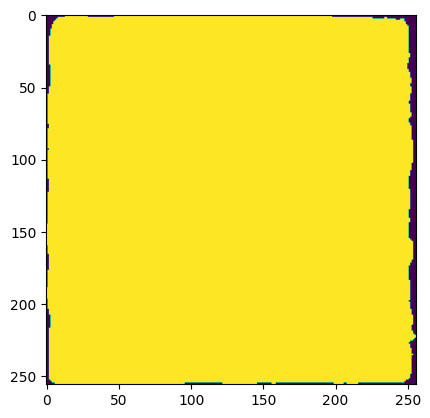

In [68]:
from matplotlib import pyplot as plt

for i in range(result.size(0)):
    out = torch.argmax(result[i], dim=0)
    out = out.cpu()
    plt.imshow(out)

In [67]:

torch.argmax(result[0], dim=0).shape

torch.Size([256, 256])

In [77]:
import os
import cv2

output_dir = "segmentation_frames"
os.makedirs(output_dir, exist_ok=True)

# Сохраняем каждый кадр сегментации как изображение
for i in range(result.size(0)):
    out = torch.argmax(result[i], dim=0)
    out = out.cpu().numpy()
    plt.imshow(out, cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f"segmentation_{i}.png"), bbox_inches='tight', pad_inches=0)
    plt.close()

# Считываем сохраненные кадры сегментации и создаем видео
output_video_path = "segmentation_video.mp4"
frame_width, frame_height = cv2.imread(os.path.join(output_dir, f"segmentation_0.png")).shape[1::-1]
fps = 30  

out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width, frame_height))

# Собираем сохраненные кадры сегментации в видео
for i in range(result.size(0)):
    img = cv2.imread(os.path.join(output_dir, f"segmentation_{i}.png"))
    out.write(img)

out.release()

print("Видео успешно сохранено:", output_video_path)


Видео успешно сохранено: segmentation_video.mp4
